In [1]:
#| default_exp workflow

/home/glect/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


,action,reward_mean,reward_std,phenotype_mean,phenotype_std,tbv_mean,tbv_std
0,-1.0,23.264389,1.084688,117.199397,1.136008,23.264388,1.084688
1,-0.5,16.092931,1.000210,110.045973,0.950591,16.092930,1.000210


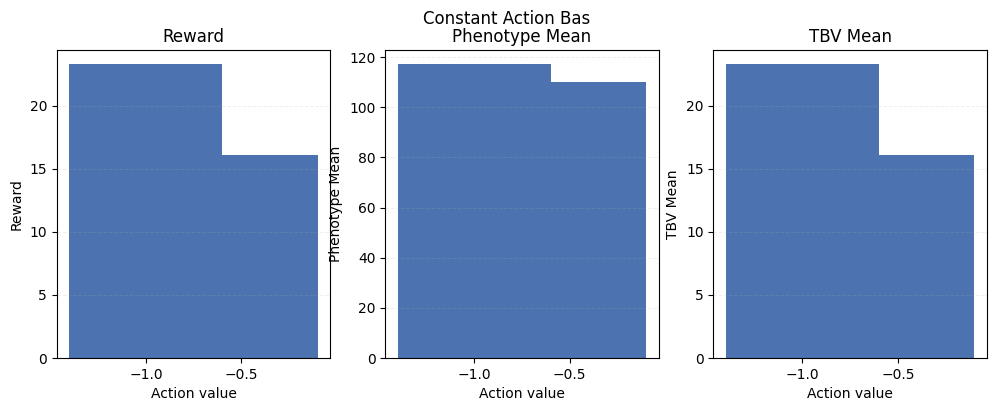

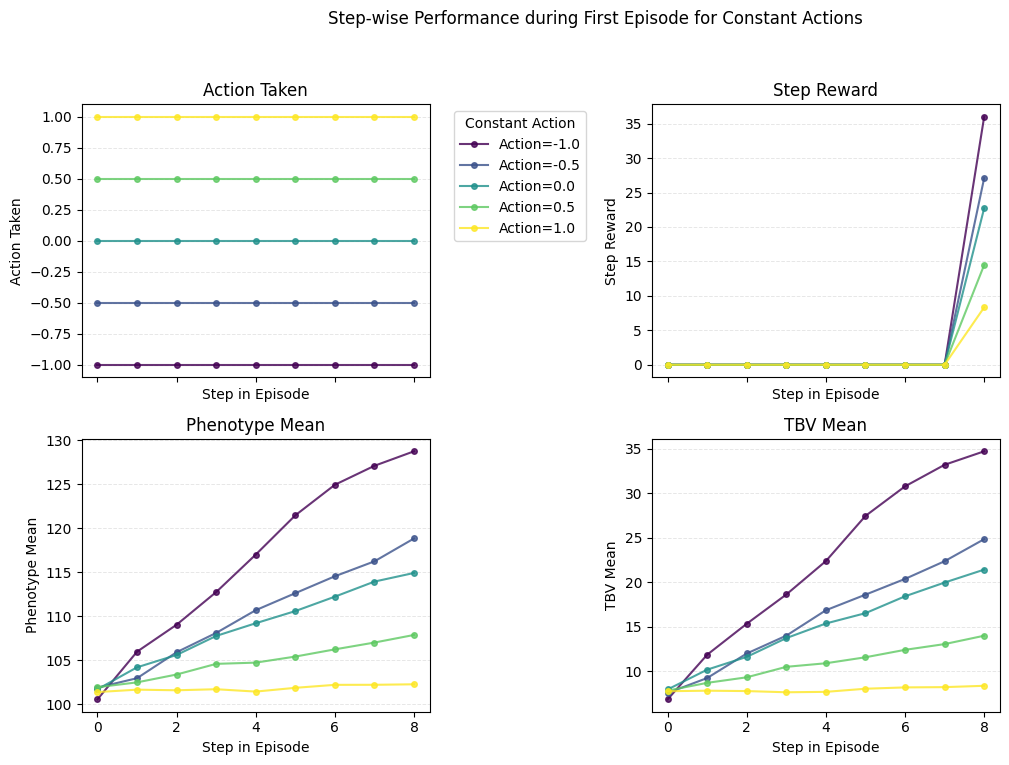


Step-wise data for the first episode of each action:


,step,action,reward,phenotype_mean,tbv_mean,action_value,episode
0,0,-1.0,0.000000,100.568954,6.842929,-1.0,0
1,1,-1.0,0.000000,105.982460,11.856910,-1.0,0
2,2,-1.0,0.000000,109.046364,15.333502,-1.0,0
3,3,-1.0,0.000000,112.755829,18.620100,-1.0,0
4,4,-1.0,0.000000,117.013939,22.373343,-1.0,0
5,5,-1.0,0.000000,121.475693,27.443542,-1.0,0
6,6,-1.0,0.000000,124.948555,30.765615,-1.0,0
7,7,-1.0,0.000000,127.105888,33.186596,-1.0,0
8,8,-1.0,36.006821,128.752426,34.700787,-1.0,0
9,0,-0.5,0.000000,101.899460,7.552630,-0.5,0


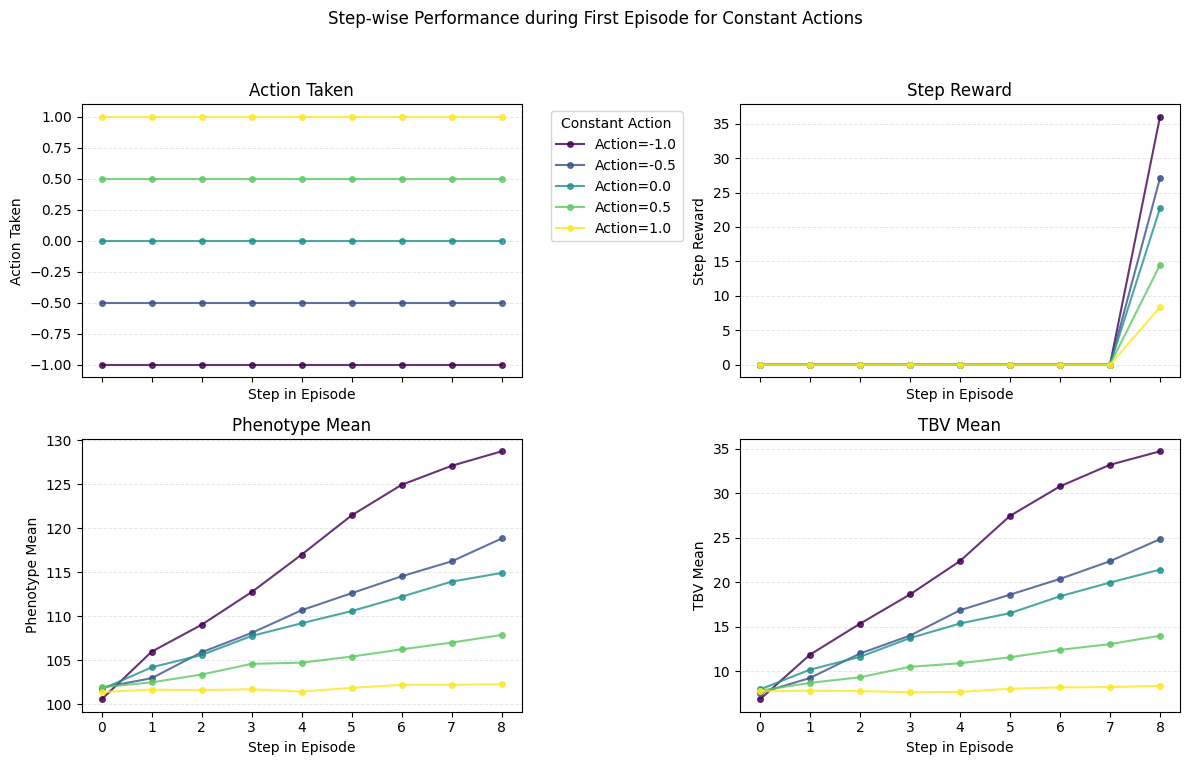

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from chewc.gym import StoaEnv
from chewc.pheno import calculate_phenotypes

plt.style.use('tableau-colorblind10')


def run_constant_action_episode(env: StoaEnv, action_value: float, rng_key: jax.Array):
    params = env.default_params
    reset_key, rng_key = jax.random.split(rng_key)
    _, state = env.reset_env(reset_key, params)

    action = jnp.array([action_value], dtype=jnp.float32)
    final_reward = 0.0

    while True:
        rng_key, step_key = jax.random.split(rng_key)
        _, state, reward, done, _ = env.step_env(step_key, state, action, params)
        final_reward = float(reward)
        if bool(done):
            break

    phenokey, _ = jax.random.split(state.key)
    phenotypes, tbv = calculate_phenotypes(
        phenokey,
        population=state.population,
        trait=env.trait_architecture,
        heritability=env.heritabilities,
    )

    phenotypes = np.asarray(phenotypes[:, 0])
    tbv = np.asarray(tbv[:, 0])
    return final_reward, float(phenotypes.mean()), float(tbv.mean())


def evaluate_constant_actions(
    env: StoaEnv,
    action_values,
    num_episodes: int = 32,
    seed: int = 0,
) -> pd.DataFrame:
    rng = jax.random.PRNGKey(seed)
    records = []

    for action in action_values:
        rewards = []
        phenotype_means = []
        tbv_means = []

        for _ in range(num_episodes):
            rng, episode_key = jax.random.split(rng)
            reward, phenotype_mean, tbv_mean = run_constant_action_episode(
                env, action, episode_key
            )
            rewards.append(reward)
            phenotype_means.append(phenotype_mean)
            tbv_means.append(tbv_mean)

        records.append(
            {
                'action': float(action),
                'reward_mean': float(np.mean(rewards)),
                'reward_std': float(np.std(rewards, ddof=1)) if num_episodes > 1 else 0.0,
                'phenotype_mean': float(np.mean(phenotype_means)),
                'phenotype_std': float(np.std(phenotype_means, ddof=1)) if num_episodes > 1 else 0.0,
                'tbv_mean': float(np.mean(tbv_means)),
                'tbv_std': float(np.std(tbv_means, ddof=1)) if num_episodes > 1 else 0.0,
            }
        )

    return pd.DataFrame.from_records(records)

gym = StoaEnv(total_gen=5)

baseline_actions = [-1.0, -0.5]
baseline_df = evaluate_constant_actions(gym, baseline_actions, num_episodes=5, seed=0)
display(baseline_df)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
metrics = [
    ('reward_mean', 'Reward'),
    ('phenotype_mean', 'Phenotype Mean'),
    ('tbv_mean', 'TBV Mean'),
]

for ax, (column, title) in zip(axes, metrics):
    ax.bar(baseline_df['action'], baseline_df[column], color='#4c72b0')
    ax.set_title(title)
    ax.set_xlabel('Action value')
    ax.set_xticks(baseline_df['action'])
    ax.set_ylabel(title)
    ax.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.7)

fig.suptitle('Constant Action Bas')
def run_constant_action_episode(env: StoaEnv, action_value: float, rng_key: jax.Array):
    """Runs a single episode with a constant action and tracks step-wise data."""
    params = env.default_params
    reset_key, rng_key = jax.random.split(rng_key)
    _, state = env.reset_env(reset_key, params)

    action = jnp.array([action_value], dtype=jnp.float32)

    # Lists to store step-wise data
    step_rewards = []
    step_phenotype_means = []
    step_tbv_means = []
    step_actions = [] # Store action at each step
    steps = []       # Store step number

    current_step = 0
    while True:
        rng_key, step_key = jax.random.split(rng_key)
        phenokey, rng_key = jax.random.split(rng_key) # Need a key for phenotype calculation each step

        # Calculate metrics *before* taking the step to align with step number
        current_phenotypes, current_tbv = calculate_phenotypes(
            phenokey,
            population=state.population,
            trait=env.trait_architecture,
            heritability=env.heritabilities,
        )
        step_phenotype_means.append(float(jnp.asarray(current_phenotypes[:, 0]).mean()))
        step_tbv_means.append(float(jnp.asarray(current_tbv[:, 0]).mean()))
        step_actions.append(action_value) # Store the constant action
        steps.append(current_step)

        # Environment step
        _, state, reward, done, _ = env.step_env(step_key, state, action, params)
        step_rewards.append(float(reward)) # Store reward received *after* the step

        current_step += 1

        if bool(done):
            # Record final state metrics if needed (or adjust logic based on when metrics should reflect state)
            # For simplicity here, we stop after the 'done' flag is True
            break

    # Final metrics calculation (optional, depending on what 'final_reward' represents)
    # phenokey_final, _ = jax.random.split(state.key)
    # phenotypes_final, tbv_final = calculate_phenotypes(
    #     phenokey_final,
    #     population=state.population,
    #     trait=env.trait_architecture,
    #     heritability=env.heritabilities,
    # )
    # final_phenotype_mean = float(jnp.asarray(phenotypes_final[:, 0]).mean())
    # final_tbv_mean = float(jnp.asarray(tbv_final[:, 0]).mean())
    final_reward = step_rewards[-1] # Example: use the last reward

    # Return step-wise data along with final metrics
    step_data = pd.DataFrame({
        'step': steps,
        'action': step_actions,
        'reward': step_rewards, # Note: reward list might be one shorter if not recorded after final step before break
        'phenotype_mean': step_phenotype_means,
        'tbv_mean': step_tbv_means
    })

    # Adjust reward list length if necessary
    if len(step_rewards) < len(steps):
         step_data = step_data.iloc[:-1].copy() # Drop last row if reward list is shorter
         step_data['reward'] = step_rewards


    return final_reward, step_data # Return final reward and the DataFrame of step data


def evaluate_constant_actions(
    env: StoaEnv,
    action_values,
    num_episodes: int = 32,
    seed: int = 0,
) -> pd.DataFrame:
    """Evaluates constant actions, collecting step-wise data for the first episode of each action."""
    rng = jax.random.PRNGKey(seed)
    # records = [] # Keeping this if you still want summary stats
    all_step_data = [] # List to store step data DataFrames

    for action in action_values:
        rewards = []
        # phenotype_means = [] # For summary stats if needed
        # tbv_means = [] # For summary stats if needed
        first_episode_step_data = None

        for i in range(num_episodes):
            rng, episode_key = jax.random.split(rng)
            final_reward, step_data = run_constant_action_episode(
                env, action, episode_key
            )
            rewards.append(final_reward)
            # phenotype_means.append(step_data['phenotype_mean'].iloc[-1]) # Example: final phenotype mean
            # tbv_means.append(step_data['tbv_mean'].iloc[-1]) # Example: final tbv mean

            if i == 0: # Store step data only for the first episode
                step_data['action_value'] = float(action) # Add action value column for grouping/labeling
                step_data['episode'] = i # Add episode identifier
                first_episode_step_data = step_data

        all_step_data.append(first_episode_step_data)

        # If you still need the summary DataFrame, uncomment and adjust this part
        # records.append(
        #     {
        #         'action': float(action),
        #         'reward_mean': float(np.mean(rewards)),
        #         'reward_std': float(np.std(rewards, ddof=1)) if num_episodes > 1 else 0.0,
        #         'phenotype_mean': float(np.mean(phenotype_means)),
        #         'phenotype_std': float(np.std(phenotype_means, ddof=1)) if num_episodes > 1 else 0.0,
        #         'tbv_mean': float(np.mean(tbv_means)),
        #         'tbv_std': float(np.std(tbv_means, ddof=1)) if num_episodes > 1 else 0.0,
        #     }
        # )

    # Concatenate step data from the first episode of each action
    combined_step_data = pd.concat(all_step_data, ignore_index=True)

    # return pd.DataFrame.from_records(records) # Return summary if needed
    return combined_step_data


# --- Simulation & Plotting ---
gym = StoaEnv(total_gen=10) # Increase generations for a longer plot

baseline_actions = [-1.0, -0.5, 0.0, 0.5, 1.0] # Evaluate more actions
step_wise_df = evaluate_constant_actions(gym, baseline_actions, num_episodes=5, seed=0) # Run simulation

# --- New Plotting Logic ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True) # Changed to 2x2 grid
axes = axes.flatten() # Flatten axes array for easy iteration

metrics_to_plot = [
    ('action', 'Action Taken'),
    ('reward', 'Step Reward'),
    ('phenotype_mean', 'Phenotype Mean'),
    ('tbv_mean', 'TBV Mean'),
]

# Group data by the constant action value used for the episode
grouped_data = step_wise_df.groupby('action_value')

# Define colors (optional, but helps distinguish lines)
colors = plt.cm.viridis(np.linspace(0, 1, len(baseline_actions)))

for ax, (column, title) in zip(axes, metrics_to_plot):
    for i, (action_val, group) in enumerate(grouped_data):
        ax.plot(group['step'], group[column], marker='o', linestyle='-', label=f'Action={action_val}', color=colors[i], markersize=4, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Step in Episode')
    ax.set_ylabel(title)
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
    if column == 'action': # Keep legend only on the first plot for clarity
         ax.legend(title="Constant Action", bbox_to_anchor=(1.05, 1), loc='upper left')
    #else:
    #     ax.legend().set_visible(False)


# Remove legend from other plots if created automatically and adjust layout
# for ax in axes[1:]:
#      if ax.get_legend():
#           ax.get_legend().remove()

fig.suptitle('Step-wise Performance during First Episode for Constant Actions')
fig.tight_layout(rect=[0, 0.03, 0.85, 0.95]) # Adjust layout to make space for legend outside

plt.show()

# Display the collected step-wise data
print("\nStep-wise data for the first episode of each action:")
display(step_wise_df)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig
